In [1]:
import numpy as np
import matplotlib.pyplot as plt

#
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Set Up Sample:
kvec = np.arange(0,1,0.01)
print(kvec.shape)

def func(a,b):
    return a * (2 + np.sin(2*np.pi*b*kvec) )

(100,)


In [102]:
# Define sample:
Avec = np.arange(1,2,0.01)
Bvec = np.arange(1,2,0.01)

Agrid, Bgrid = np.meshgrid(Avec,Bvec)
Atrain, Btrain = Agrid.flatten(), Bgrid.flatten()
Ptrain = np.vstack( (Atrain,Btrain) ).T

Ftrain = [ func(Atrain[ii],Btrain[ii]) for ii in range(len(Atrain)) ]
Ftrain = np.array(Ftrain)

# Split into validation set 30-70
iis = np.random.rand(len(Atrain)) > 0.3

Pval = Ptrain[~iis,:]
Fval = Ftrain[~iis,:]

Ptrain = Ptrain[iis,:]
Ftrain = Ftrain[iis,:]

In [160]:
# Construct Principle Components
mean = np.mean(Ftrain,axis=0); mean = np.array(mean, dtype='float32')
sigmas = np.std(Ftrain,axis=0); sigmas = np.array(sigmas,dtype='float32')

cov_matrix = np.cov( ((Ftrain - mean)/ sigmas).T )

In [161]:
w, v = np.linalg.eigh(cov_matrix)

# flip to rank in ascending eigenvalue
w = np.flip(w)
v = np.flip(v, axis=1)

v = np.array(v, dtype='float32')

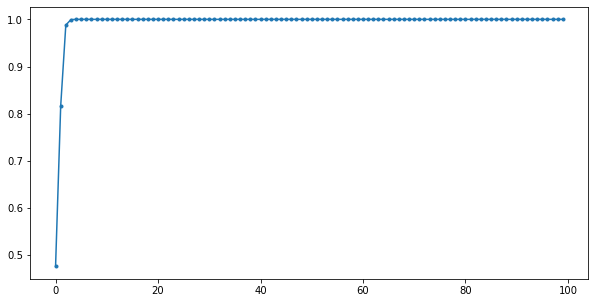

In [162]:
plt.figure(figsize=(10,5))

plt.plot(np.cumsum(w)/np.sum(w), '.-')

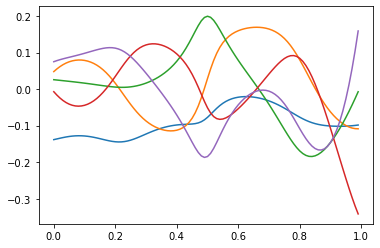

In [163]:
# Plot the first ten principle components:

for ii in range(5):
    plt.plot(kvec, v[:,ii])

In [164]:
# See how much we can do with the first ten principle components:
a, b = 1.153, 1.881
Yreal = func(a,b)

n_components = 10
YdotV = np.dot( (Yreal-mean)/sigmas, v)
Ypca = sigmas * np.dot(v[:,:n_components], YdotV[:n_components]) + mean

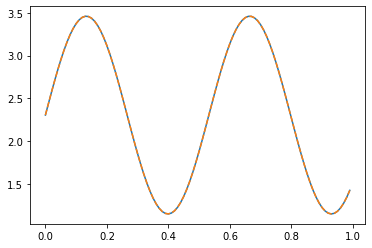

In [165]:
plt.plot(kvec, Yreal)
plt.plot(kvec, Ypca, '--')

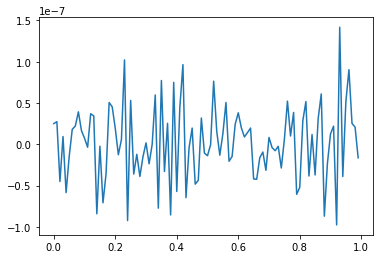

In [166]:
plt.plot(kvec, Ypca/Yreal - 1)

In [167]:
# Now let's set up the PCA based emulator:
 
class Emulator(tf.keras.Model):
    
    def __init__(self):
        super(Emulator, self).__init__()
        
        trainable = True
        
        self.n_parameters = 2
        self.n_hidden = [100,100,100]
        self.n_components = n_components
        self.nks = 100
        
        self.architecture = [self.n_parameters] + self.n_hidden + [self.n_components]
        self.n_layers = len(self.architecture) - 1

        self.W = []
        self.b = []
        self.alphas = []
        self.betas = [] 
        
        for i in range(self.n_layers):
            self.W.append(tf.Variable(tf.random.normal([self.architecture[i], self.architecture[i+1]], 0., np.sqrt(2./self.n_parameters)), name="W_" + str(i), trainable=trainable))
            self.b.append(tf.Variable(tf.zeros([self.architecture[i+1]]), name = "b_" + str(i), trainable=trainable))
        for i in range(self.n_layers-1):
            self.alphas.append(tf.Variable(tf.random.normal([self.architecture[i+1]]), name = "alphas_" + str(i), trainable=trainable))
            self.betas.append(tf.Variable(tf.random.normal([self.architecture[i+1]]), name = "betas_" + str(i), trainable=trainable))
            
    def activation(self, x, alpha, beta):
        return tf.multiply(tf.add(beta, tf.multiply(tf.sigmoid(tf.multiply(alpha, x)), tf.subtract(1.0, beta)) ), x)
    
    @tf.function
    def call(self, parameters):
        
        outputs = []
        #layers = [tf.divide(tf.subtract(parameters, self.parameters_shift), self.parameters_scale)]
        
        x = parameters
        
        for i in range(self.n_layers - 1):
            
            # linear network operation
            x = tf.add(tf.matmul(x, self.W[i]), self.b[i])
            
            # non-linear activation function
            x = self.activation(x, self.alphas[i], self.betas[i])

        # linear output layer
        x = tf.add(tf.matmul(x, self.W[-1]), self.b[-1])
        
        x = tf.add(tf.multiply(sigmas,tf.matmul(x,v[:,:self.n_components].T)),mean)

        return x

In [168]:
# Set up learning hyperparameters:
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
nbatchs = [16, 32, 64, 128, 256]

In [172]:
# Now actually start the emulator
emulator = Emulator()
emulator.compile(optimizer='adam',loss='mse',metrics=['mse'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

for lr, nbatch in zip(lrs,nbatchs):
    print("Using learning rate, batch size:  %.2e, %d."%(lr,nbatch))
    
    emulator.optimizer.lr = lr
    emulator.fit(Ptrain,Ftrain,epochs=1000,batch_size=nbatch,validation_data=(Pval,Fval),callbacks=[es],verbose=2)

Using learning rate, batch size:  1.00e-02, 16.
Epoch 1/1000
437/437 - 2s - loss: 5711.6924 - mse: 5711.6924 - val_loss: 10.4459 - val_mse: 10.4459
Epoch 2/1000
437/437 - 1s - loss: 6.1106 - mse: 6.1106 - val_loss: 3.6770 - val_mse: 3.6770
Epoch 3/1000
437/437 - 1s - loss: 3.3698 - mse: 3.3698 - val_loss: 3.4067 - val_mse: 3.4067
Epoch 4/1000
437/437 - 1s - loss: 3.0931 - mse: 3.0931 - val_loss: 2.6563 - val_mse: 2.6563
Epoch 5/1000
437/437 - 1s - loss: 8.9838 - mse: 8.9838 - val_loss: 4.2143 - val_mse: 4.2143
Epoch 6/1000
437/437 - 1s - loss: 15.4277 - mse: 15.4277 - val_loss: 8.0920 - val_mse: 8.0920
Epoch 7/1000
437/437 - 1s - loss: 3.7622 - mse: 3.7622 - val_loss: 20.6744 - val_mse: 20.6744
Epoch 8/1000
437/437 - 1s - loss: 35.4736 - mse: 35.4736 - val_loss: 5.1331 - val_mse: 5.1331
Epoch 9/1000
437/437 - 1s - loss: 2.0820 - mse: 2.0820 - val_loss: 8.4799 - val_mse: 8.4799
Epoch 10/1000
437/437 - 1s - loss: 5.3091 - mse: 5.3091 - val_loss: 10.4612 - val_mse: 10.4612
Epoch 11/1000
4

Max.abs.error  0.00011513150761621738  at x= 0.37


Text(0.5, 0, 'k')

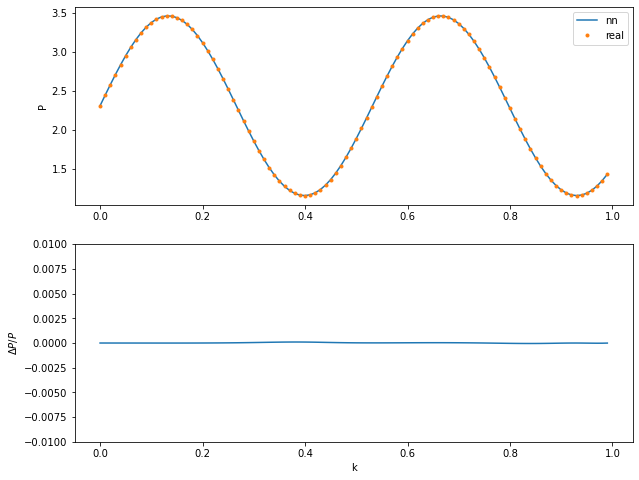

In [173]:
# Test it on some random parameters:

a, b = 1.153, 1.881

Xtest = np.array([a,b])[None,:]
Yreal = func(a,b)

Ylearn = emulator.predict(Xtest)[0,:]
abserr = np.max(np.abs(Ylearn-Yreal))
maxloc = np.argmax(np.abs(Ylearn-Yreal))
print("Max.abs.error ",abserr," at x=",kvec[maxloc])

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(kvec, Ylearn, label='nn')
plt.plot(kvec, Yreal, '.', label='real')

plt.ylabel('P')
plt.legend()

plt.subplot(2,1,2)
plt.plot(kvec, Ylearn/Yreal - 1)
plt.ylim(-0.01,0.01)
plt.ylabel(r'$\Delta P/P$')
plt.xlabel('k')

In [174]:
emulator.summary()

Model: "emulator_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 22,110
Trainable params: 22,110
Non-trainable params: 0
_________________________________________________________________
